In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 
from sklearn.ensemble import RandomForestClassifier 
from glob import glob,iglob
from osgeo import gdal , gdal_array
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from write_geotif import CreateGeoTiff
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

from yellowbrick.model_selection import FeatureImportances

from tqdm import tqdm
import joblib 
import earthpy.plot as ep

Data processing: to preprocess the data for some predictive modeling task, ensuring proper data types, handling categorical variables, and splitting the data into training and testing sets.

In [2]:
#Reading Data:This line reads a CSV file named "point_final.csv" into a pandas DataFrame (data_org) using pd.read_csv(). The delimiter used in the CSV file is ;.
data_org=pd.read_csv("point_final.csv",delimiter=";")

In [3]:
#Data Preprocessing:Here, a copy of the original DataFrame is created (data) to perform data preprocessing. In this step, commas in the data are replaced with periods. This is likely done to ensure consistency in representing decimal numbers.
data=data_org.copy()
data=data.replace(",",".",regex=True)

In [4]:
#Checking Data Types:This line prints out the data types of each column in the DataFrame data.
data.dtypes

OID_                  int64
Landslide             int64
LONGITUDE            object
LATITUDE             object
DTM_merged           object
slope                object
LULC                  int64
profile_curvature    object
plan_curvature       object
dist_acc_road        object
dist_river           object
NDVI                 object
rain                 object
aspect                int64
dtype: object

In [5]:
#Removing First Column:This line removes the first column from the DataFrame data. It's common in data processing tasks to remove index columns or columns that are not needed for analysis.
data=data.iloc[:,1:]

In [6]:
# Separate features and target variable: Here, the DataFrame X is created containing all the features (independent variables) except for the 'Landslide' column, while y contains only the 'Landslide' column, which is the target variable (dependent variable).
X=data.drop('Landslide', axis=1).copy()
y=data.loc[:,'Landslide'].copy()

In [7]:
X.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,LULC,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,aspect
0,91682.5802,92003.1689,373.0174866,0.787680209,4,-0.06276847,0.033129507,411.9653931,180.7027969,0.362031567,67.34322357,7
1,55682.266,104415.2486,385.8379517,16.82241821,2,-0.269385904,0.087632157,258.0426331,148.4890594,0.335763618,82.88248444,6
2,76261.6868,66915.8101,294.2075043,10.79049492,4,0.272305995,-0.318835378,580.9100647,373.3664398,0.4827781,71.41384125,8
3,56772.518,102116.9275,455.8366547,24.03018665,2,-0.174597126,0.955412209,539.9199219,80.76198578,0.265183495,82.81878662,8
4,67847.8478,81082.7308,315.7912445,2.850139856,4,0.11769855,0.001954662,138.8272247,569.63797,0.463345363,75.07782745,6


In [8]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Landslide, dtype: int64

In [9]:
#Converting Data Types:This line converts all the columns in DataFrame X to float data type.
X=X.astype(float)
X.dtypes

LONGITUDE            float64
LATITUDE             float64
DTM_merged           float64
slope                float64
LULC                 float64
profile_curvature    float64
plan_curvature       float64
dist_acc_road        float64
dist_river           float64
NDVI                 float64
rain                 float64
aspect               float64
dtype: object

In [10]:
#Converting Categorical Variables:Here, specific columns ('aspect' and 'LULC') are converted to string data type. This might be done in preparation for one-hot encoding categorical variables.
#!!!!!uncomment when you have your aspect as categorical/factor variable fro example 1,2,3,4.....
X['aspect']=X['aspect'].astype(str)
X['LULC']=X['LULC'].astype(str)

In [11]:
#Checking Data Types: This line prints out the data type of the target variable y.
y.dtypes

dtype('int64')

In [12]:
#Identifying Categorical Columns:This line identifies categorical columns in the DataFrame X and stores their column names in the list cols_obj.
cols_obj=X.columns[X.dtypes=='object'].values.tolist()
cols_obj
#One-Hot Encoding Categorical Variables: This line performs one-hot encoding on the categorical variables identified earlier and stores the result in the DataFrame X_encoded.
X_encoded=pd.get_dummies(X,columns=cols_obj)

#Train-Test Split:This line splits the data into training and testing sets using train_test_split() function from scikit-learn. The training set comprises 70% of the data, and stratification is applied based on the target variable y.
X_train, X_test, y_train, y_test=train_test_split(X_encoded,y, random_state=6768, train_size=0.70, stratify=y)



In [13]:
cols_obj

['LULC', 'aspect']

In [14]:
X_train.shape

(799, 26)

In [15]:
X_test.shape

(343, 26)

In [16]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

 XGBOOST: This code segment primarily focuses on training an XGBoost classifier, evaluating its performance, and optimizing its hyperparameters using grid search cross-validation. Let's break down the code step by step:
 Overall, this code trains an XGBoost classifier, evaluates its performance, visualizes the confusion matrix, and tunes its hyperparameters using grid search cross-validation to find the best combination of hyperparameters.

In [17]:
#Defining XGBoost Classifier:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=np.nan,eval_metric='aucpr', early_stopping_rounds=10,seed=42)
#Fitting the Classifier: This line trains the XGBoost classifier (clf_xgb) on the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])


[0]	validation_0-aucpr:0.85562
[1]	validation_0-aucpr:0.87215
[2]	validation_0-aucpr:0.86338
[3]	validation_0-aucpr:0.87025
[4]	validation_0-aucpr:0.89001
[5]	validation_0-aucpr:0.89830
[6]	validation_0-aucpr:0.89287
[7]	validation_0-aucpr:0.89529
[8]	validation_0-aucpr:0.89652
[9]	validation_0-aucpr:0.90158
[10]	validation_0-aucpr:0.90822
[11]	validation_0-aucpr:0.90658
[12]	validation_0-aucpr:0.90134
[13]	validation_0-aucpr:0.90312
[14]	validation_0-aucpr:0.90852
[15]	validation_0-aucpr:0.90706
[16]	validation_0-aucpr:0.90534
[17]	validation_0-aucpr:0.90504
[18]	validation_0-aucpr:0.90448
[19]	validation_0-aucpr:0.89736
[20]	validation_0-aucpr:0.89497
[21]	validation_0-aucpr:0.89505
[22]	validation_0-aucpr:0.89530
[23]	validation_0-aucpr:0.89439
[24]	validation_0-aucpr:0.89586


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
class_mapper={0:"No", 1:"Yes"}

In [19]:
class_mapper.keys()

dict_keys([0, 1])

In [20]:
class_mapper.values()

dict_values(['No', 'Yes'])

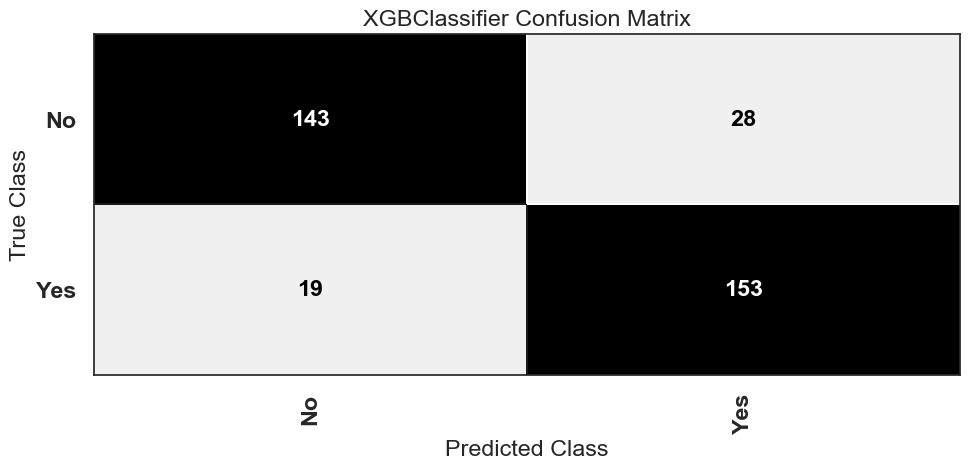

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [21]:
sns.set(style="white",font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
#This part visualizes the confusion matrix of the trained model. It plots a confusion matrix using the ConfusionMatrix function, which helps in visualizing the performance of the classifier.
fig,ax=plt.subplots(figsize=(10,5))
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()),cmap="Greys")
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()

This code segment seems to perform several tasks after obtaining the optimal parameters through grid search cross-validation. Let's break down the steps:

In [22]:
#Hyperparameter Tuning with Grid Search: Here, a dictionary param_grid is defined, which contains the hyperparameters and their respective values to be tuned.
param_grid={'max_depth':[3,4,5],
    'learning_rate':[0.1,0.05,0.01],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]}

In [23]:
#Grid Search Cross-Validation:An instance of GridSearchCV (optimal_params) is created with the XGBoost classifier as the estimator, the specified parameter grid, and other settings like verbosity, number of parallel jobs, and cross-validation folds.
optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42,subsample=0.9,eval_metric='aucpr',early_stopping_rounds=10),
                           param_grid=param_grid,verbose=2,n_jobs=16,cv=5)

In [24]:
#Fitting the Grid Search:The fit method is called on optimal_params to perform the grid search cross-validation on the training data. The evaluation is done on the test set as well.
optimal_params.fit(X_train,y_train,
                   verbose=True,
                   eval_set=[(X_test,y_test)])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[0]	validation_0-aucpr:0.75383
[1]	validation_0-aucpr:0.75165
[2]	validation_0-aucpr:0.78445
[3]	validation_0-aucpr:0.78455
[4]	validation_0-aucpr:0.78820
[5]	validation_0-aucpr:0.78440
[6]	validation_0-aucpr:0.78089
[7]	validation_0-aucpr:0.81208
[8]	validation_0-aucpr:0.83142
[9]	validation_0-aucpr:0.84371
[10]	validation_0-aucpr:0.84680
[11]	validation_0-aucpr:0.85124
[12]	validation_0-aucpr:0.85354
[13]	validation_0-aucpr:0.86112
[14]	validation_0-aucpr:0.86464
[15]	validation_0-aucpr:0.87318
[16]	validation_0-aucpr:0.88551
[17]	validation_0-aucpr:0.88494
[18]	validation_0-aucpr:0.88591
[19]	validation_0-aucpr:0.88622
[20]	validation_0-aucpr:0.88622
[21]	validation_0-aucpr:0.88749
[22]	validation_0-aucpr:0.88948
[23]	validation_0-aucpr:0.88596
[24]	validation_0-aucpr:0.88820
[25]	validation_0-aucpr:0.88467
[26]	validation_0-aucpr:0.88292
[27]	validation_0-aucpr:0.88292
[28]	validation_0-aucpr:0.89115
[29]	validation_0-

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=16,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             verbose=2)

In [25]:
#Best Parameters:This line prints out the best parameters found by the grid search cross-validation.
optimal_params.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 1}

In [26]:
#Setting up XGBoost Classifier with Optimal Parameters: Here, an instance of the XGBoost classifier (clf_xgb) is created with the optimal parameters obtained from grid search cross-validation. Additionally, other settings such as the objective function, seed, and subsample are specified.
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=0,eval_metric='aucpr', early_stopping_rounds=10,seed=4442,
                          **optimal_params.best_params_,subsample=0.9)

In [27]:
#Fitting the Classifier and Training Set:This line fits the XGBoost classifier to the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.78272
[1]	validation_0-aucpr:0.81057
[2]	validation_0-aucpr:0.83230
[3]	validation_0-aucpr:0.82942
[4]	validation_0-aucpr:0.83194
[5]	validation_0-aucpr:0.83093
[6]	validation_0-aucpr:0.86711
[7]	validation_0-aucpr:0.86355
[8]	validation_0-aucpr:0.86940
[9]	validation_0-aucpr:0.86883
[10]	validation_0-aucpr:0.86803
[11]	validation_0-aucpr:0.87126
[12]	validation_0-aucpr:0.87300
[13]	validation_0-aucpr:0.87522
[14]	validation_0-aucpr:0.88098
[15]	validation_0-aucpr:0.88002
[16]	validation_0-aucpr:0.87784
[17]	validation_0-aucpr:0.88160
[18]	validation_0-aucpr:0.88142
[19]	validation_0-aucpr:0.88271
[20]	validation_0-aucpr:0.88351
[21]	validation_0-aucpr:0.88353
[22]	validation_0-aucpr:0.88200
[23]	validation_0-aucpr:0.88179
[24]	validation_0-aucpr:0.88400
[25]	validation_0-aucpr:0.88501
[26]	validation_0-aucpr:0.88497
[27]	validation_0-aucpr:0.88862
[28]	validation_0-aucpr:0.88806
[29]	validation_0-aucpr:0.89331
[30]	validation_0-aucpr:0.89471
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
X_train

,LONGITUDE,LATITUDE,DTM_merged,slope,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,...,aspect_0.0,aspect_1.0,aspect_2.0,aspect_3.0,aspect_4.0,aspect_5.0,aspect_6.0,aspect_7.0,aspect_8.0,aspect_9.0
321,49848.0878,100267.0885,404.632416,16.809582,0.135305,-0.005950,66.925327,97.977036,0.331368,84.384460,...,False,False,False,False,False,True,False,False,False,False
1115,89695.0000,90019.0000,353.415008,17.768637,-0.632733,-0.768533,70.000000,594.229767,0.450290,67.041664,...,False,False,False,False,False,True,False,False,False,False
376,82078.0651,98264.6255,306.773453,2.824122,0.013427,0.054874,30.805843,83.297642,0.501121,69.443787,...,False,False,False,True,False,False,False,False,False,False
624,56854.4194,65176.4916,400.808990,2.743535,-0.021748,-0.114540,147.492371,601.791504,0.408595,81.559036,...,False,False,True,False,False,False,False,False,False,False
575,77413.7941,81349.4616,230.217537,3.446514,0.026919,-0.146082,159.050308,245.718338,0.351439,69.168785,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,81659.0355,90147.9564,304.052490,12.033729,-0.091309,0.003311,139.846344,78.924011,0.413930,69.559464,...,False,False,False,False,False,True,False,False,False,False
1076,92989.0000,63595.0000,229.800003,19.388506,0.417075,0.466161,421.921783,258.052322,0.487769,65.642372,...,False,False,False,False,False,False,False,False,True,False
796,75383.1660,89034.8312,309.070007,1.294650,-0.069368,0.001527,444.342224,248.471329,0.319260,68.575142,...,False,False,True,False,False,False,False,False,False,False
1048,79765.0000,101829.0000,241.242897,8.725870,1.713025,-0.086424,74.632431,62.209316,0.460003,68.849998,...,False,False,False,True,False,False,False,False,False,False


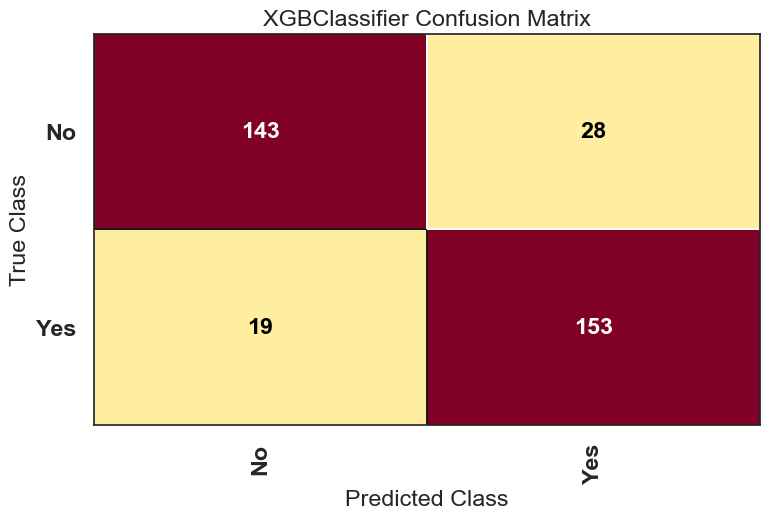

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
#Visualizing Confusion Matrix:This section visualizes the confusion matrix of the trained model using the ConfusionMatrix visualizer. It helps in understanding the model's performance in terms of true positive, true negative, false positive, and false negative predictions.
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()))
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()),cmap="Greys")
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()

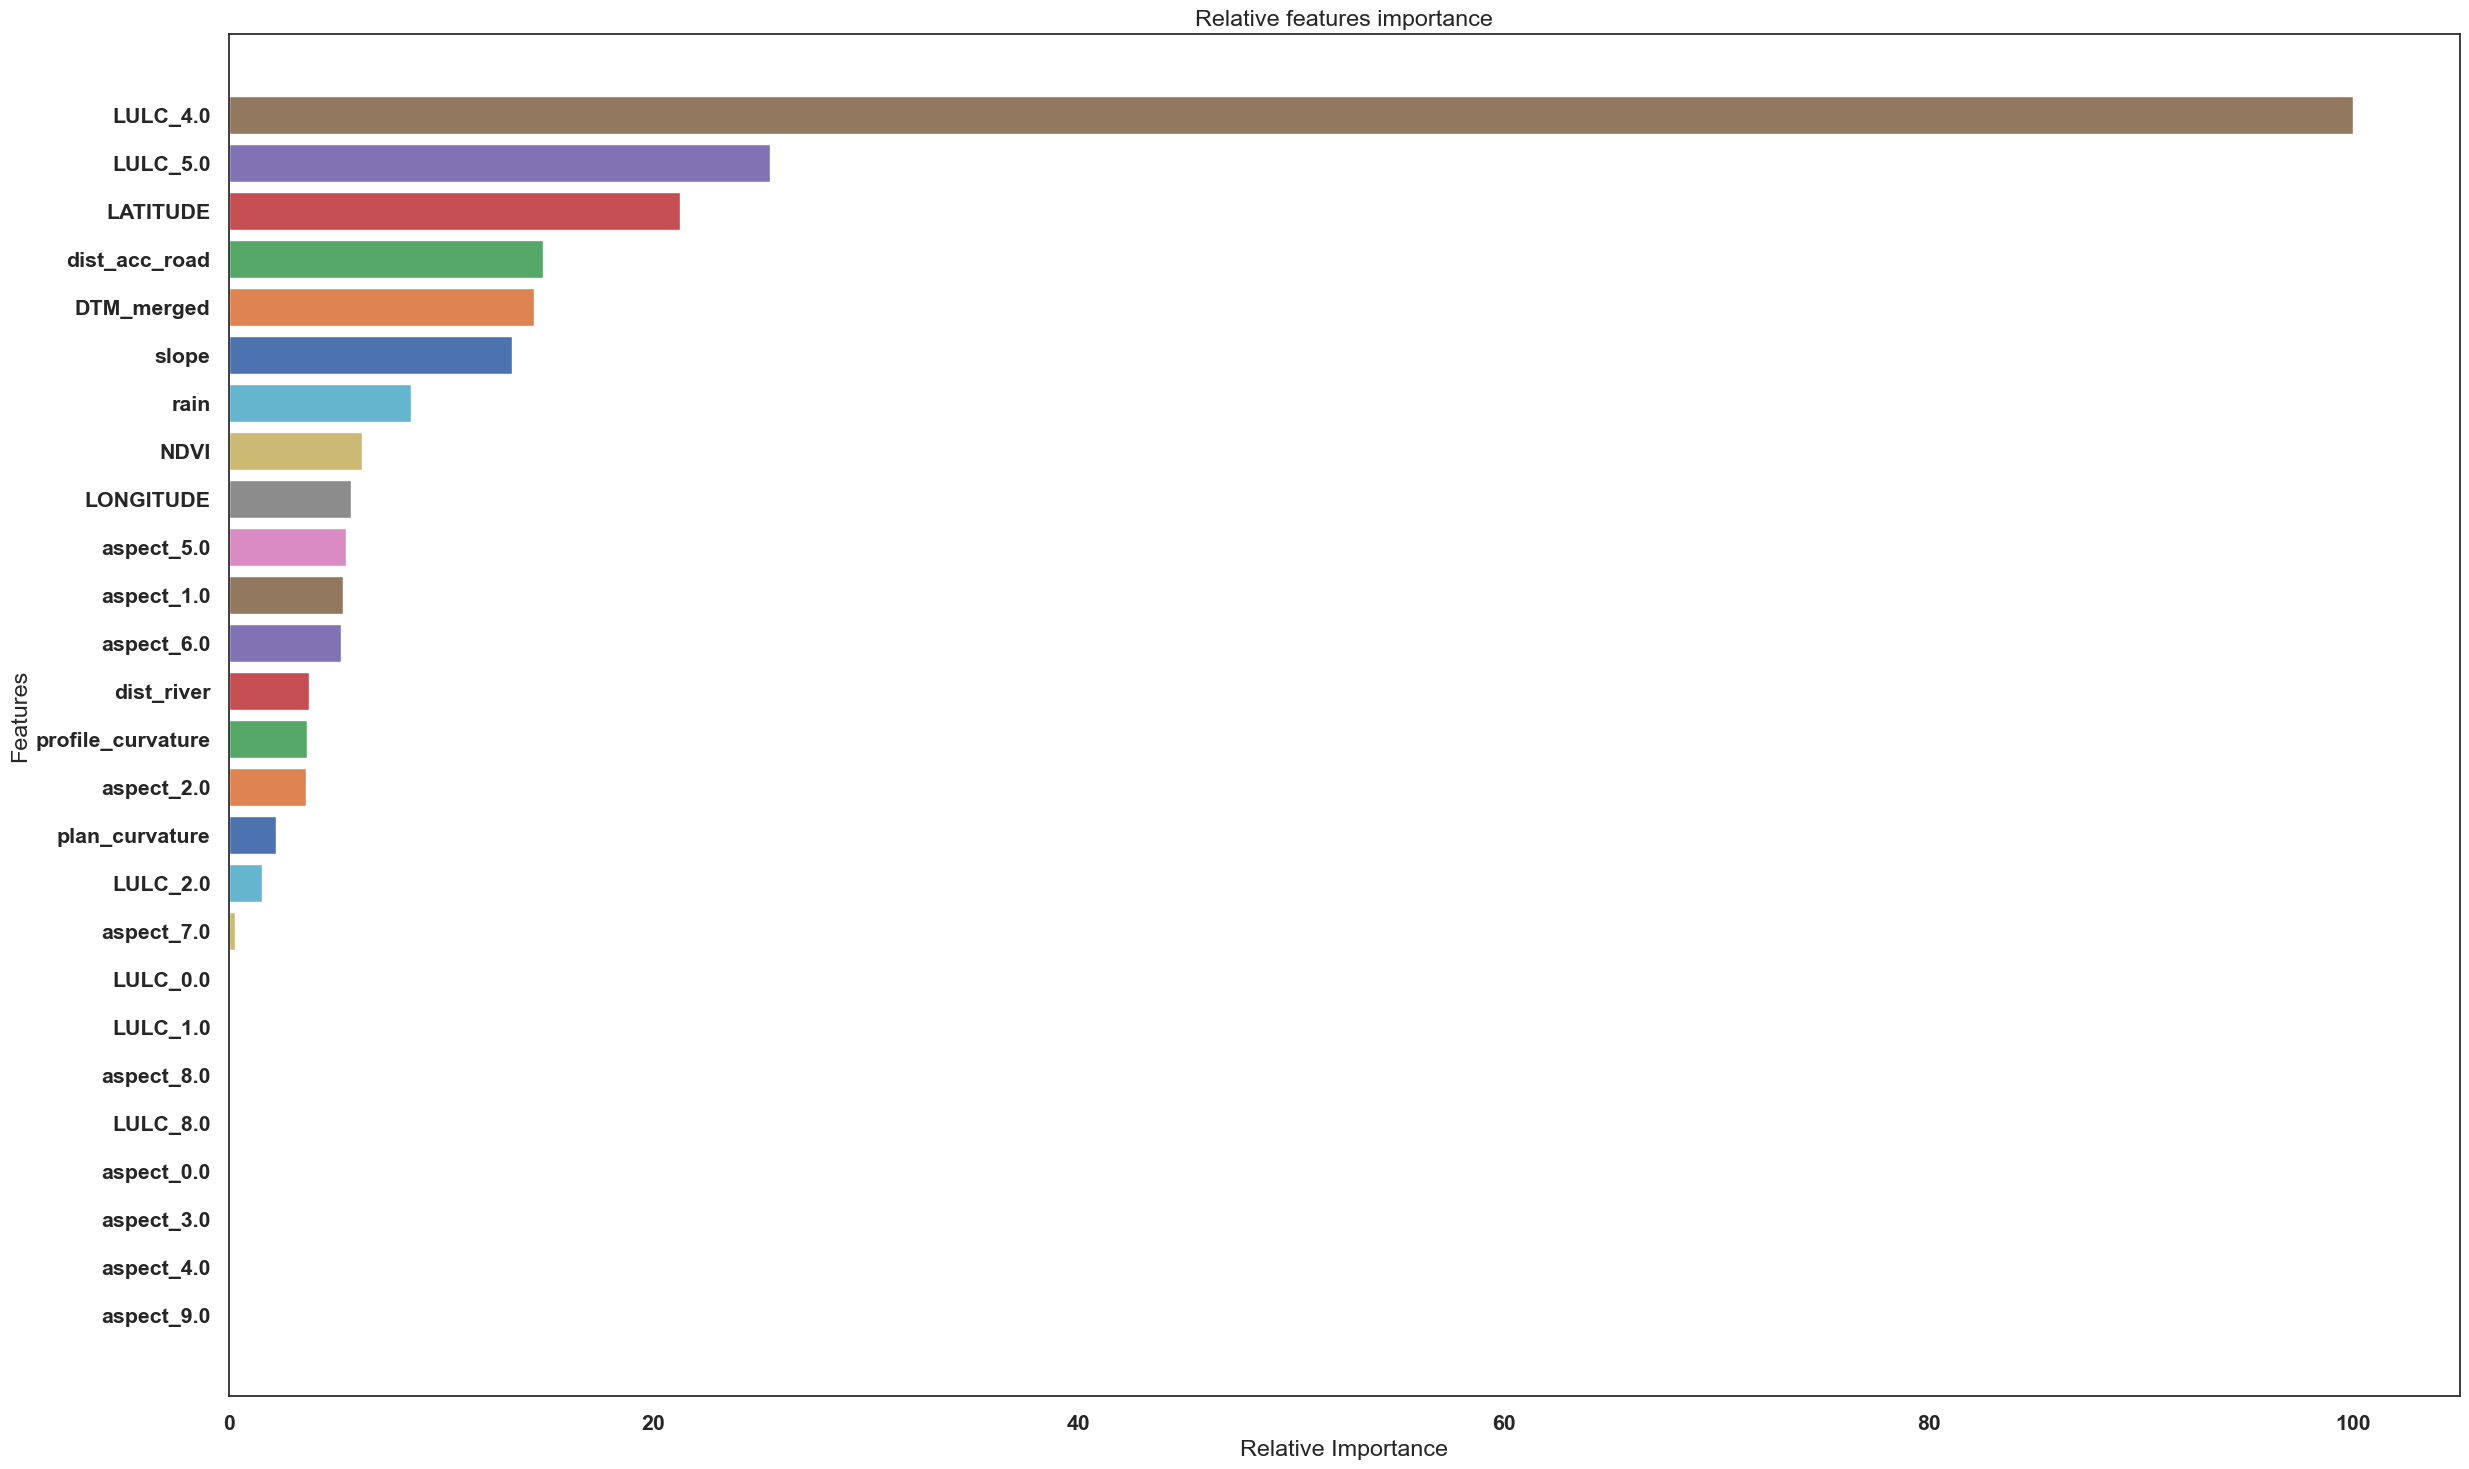

In [30]:
#Visualizing Feature Importances:Here, the code visualizes the relative importance of features in predicting the target variable using the FeatureImportances visualizer. This helps in understanding which features are more influential in the model's predictions
fig,ax=plt.subplots(figsize=(25,15))
viz = FeatureImportances(clf_xgb, relative=True, ax=ax)

viz.fit(X_train, y_train)
ax.set(title="Relative features importance", ylabel="Features", xlabel="Relative Importance")
fig.tight_layout()


In [31]:
original_palette = sns.color_palette("Greys")

# Create a reversed version of the palette
reversed_palette = original_palette[::-1]

In [32]:
#Visualizing Classification Report: This line initializes a visualizer for generating a classification report. It provides a detailed summary of the model's performance, including precision, recall, F1-score, and support for each class
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)

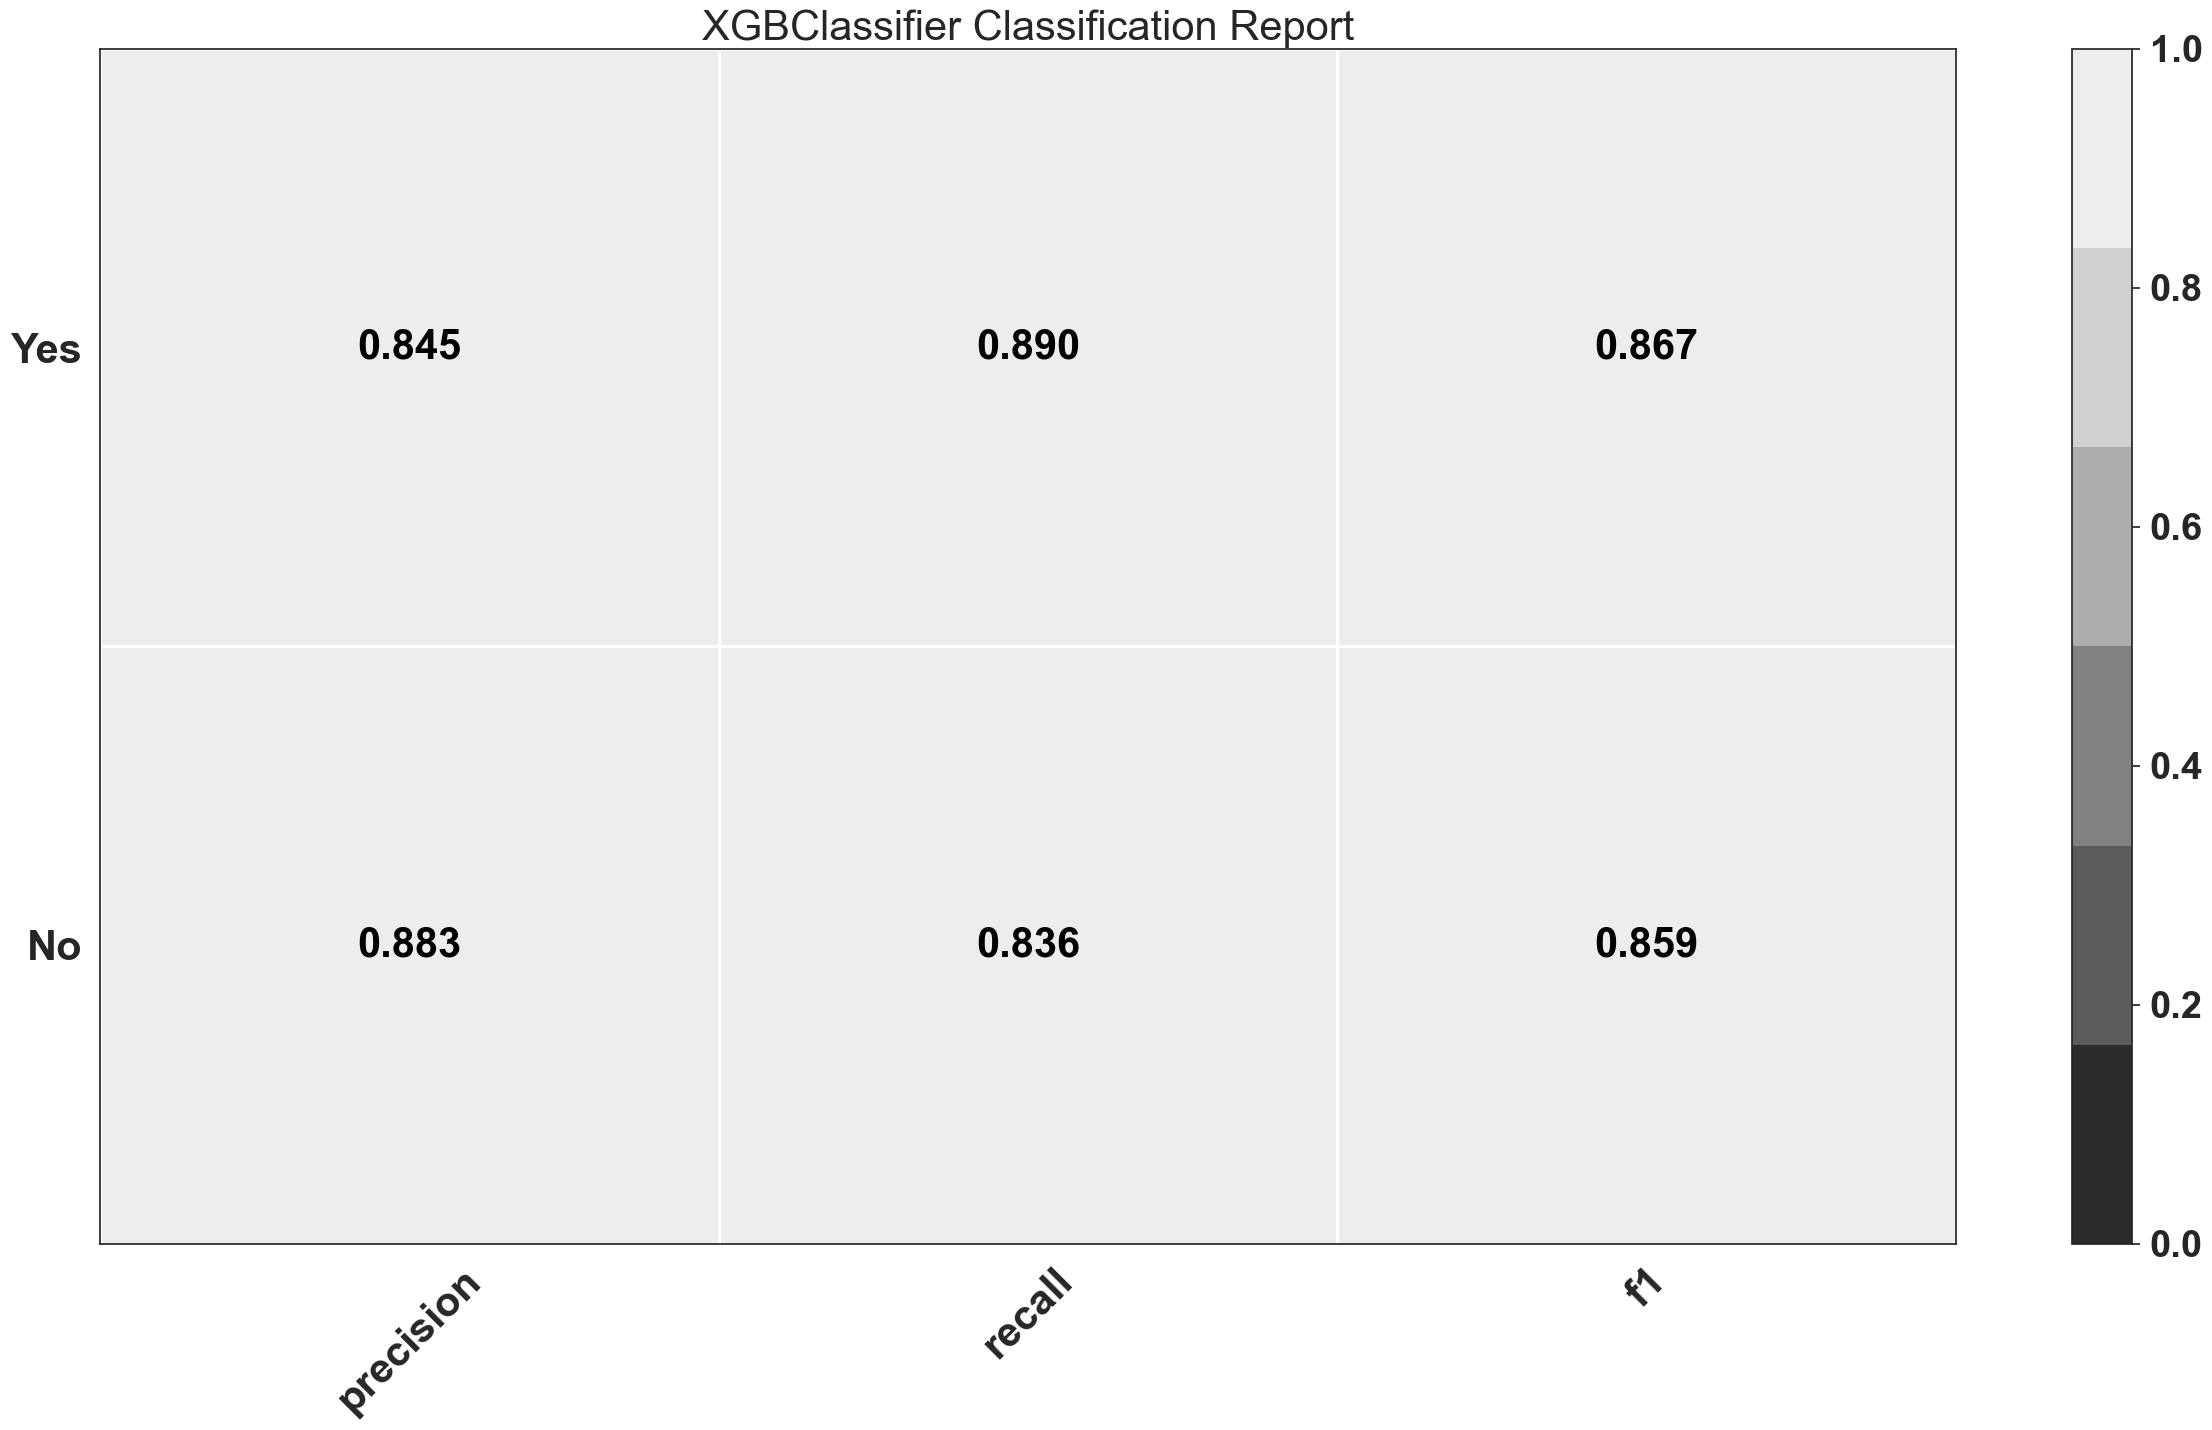

In [33]:
#Fitting and Displaying the Classification Report:This section fits the visualizer to the training data, evaluates it on the test data, and then displays the classification report. Additionally, it saves the visualization as an image file named "accuracy_assessment.png".
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=2.5, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
fig,ax=plt.subplots(figsize=(25,15))

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="./accuracy_assessment.png")    
fig.tight_layout()

Overall, this code segment aims to provide a comprehensive assessment of the XGBoost classifier's performance, including visualizations of feature importances, confusion matrix, and a detailed classification report.

## prediction for the entire image 

This code segment is aimed at making predictions for an entire image using the trained XGBoost classifier and then saving the predicted probabilities as a GeoTIFF file. Let's break down the steps:

In [34]:
#Loading Image Files:
full_data_files=glob("./data/*.tif")

In [35]:
full_data_files

['./data\\aspect_clip.tif',
 './data\\clip_dtm.tif',
 './data\\dist_riv_mask.tif',
 './data\\DTM_merged_crop1.tif',
 './data\\LULC_clip1.tif',
 './data\\NDVI_clip.tif',
 './data\\ndvi_rescale.tif',
 './data\\ndvi_rescale1.tif',
 './data\\plan_curvature.tif',
 './data\\plan_cur_clip.tif',
 './data\\profile_curvature.tif',
 './data\\prof_cur_clip.tif',
 './data\\rain_clip.tif',
 './data\\rain_resample.tif',
 './data\\rain_resample1.tif',
 './data\\reclass_aspect111.tif',
 './data\\resample_lulc.tif',
 './data\\resample_lulc1.tif',
 './data\\river_clip.tif',
 './data\\road_clip.tif',
 './data\\road_resample.tif',
 './data\\slope1_clip.tif',
 './data\\slope_resample.tif']

In [36]:
files_sorted = ['./data/dist_riv_mask.tif',
                './data/DTM_merged_crop1.tif',
                './data/ndvi_rescale.tif',
                './data/plan_curvature.tif',
                './data/profile_curvature.tif',
                './data/rain_resample.tif',
                './data/reclass_aspect111.tif',
                './data/resample_lulc.tif',
                './data/road_resample.tif',
                './data/slope_resample.tif']


In [37]:
X_encoded.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,...,aspect_0.0,aspect_1.0,aspect_2.0,aspect_3.0,aspect_4.0,aspect_5.0,aspect_6.0,aspect_7.0,aspect_8.0,aspect_9.0
0,91682.5802,92003.1689,373.017487,0.787680,-0.062768,0.033130,411.965393,180.702797,0.362032,67.343224,...,False,False,False,False,False,False,False,True,False,False
1,55682.2660,104415.2486,385.837952,16.822418,-0.269386,0.087632,258.042633,148.489059,0.335764,82.882484,...,False,False,False,False,False,False,True,False,False,False
2,76261.6868,66915.8101,294.207504,10.790495,0.272306,-0.318835,580.910065,373.366440,0.482778,71.413841,...,False,False,False,False,False,False,False,False,True,False
3,56772.5180,102116.9275,455.836655,24.030187,-0.174597,0.955412,539.919922,80.761986,0.265183,82.818787,...,False,False,False,False,False,False,False,False,True,False
4,67847.8478,81082.7308,315.791245,2.850140,0.117699,0.001955,138.827225,569.637970,0.463345,75.077827,...,False,False,False,False,False,False,True,False,False,False


In [38]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [39]:
# Function to read a single TIFF file as a numpy array
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if dataset is None:
        print(f"Failed to open file: {file_path}")
        return None
    band = dataset.GetRasterBand(1)
    array = band.ReadAsArray()
    dataset = None  # Close the dataset
    return array

# Read each TIFF file and store the arrays in a list
arrays = [read_tiff(file) for file in files_sorted]

KeyboardInterrupt: 

In [41]:

full_data_array = []
files_sorted = ['./data/dist_riv_mask.tif',
                './data/DTM_merged_crop1.tif',
                './data/ndvi_rescale.tif',
                './data/plan_curvature.tif',
                './data/profile_curvature.tif',
                './data/rain_resample.tif',
                './data/reclass_aspect111.tif',
                './data/resample_lulc.tif',
                './data/road_resample.tif',
                './data/slope_resample.tif'] # Your sorted list of TIFF file paths

for i in files_sorted:
    dataset = gdal.Open(i)
    # Read the entire array
    full_data_array.append(dataset.ReadAsArray())

In [39]:
#Loading Image Data:Here, each TIFF file is opened using GDAL, and its data is read as an array within a specified subset.
#full_data_array=[]
#subset=(0,0, 6860,4064)
#for i in files_sorted:
    #full_data_array.append(gdal.Open(i).ReadAsArray(*subset))

In [46]:
#temp=gdal.Open(files_sorted[3])
#temp=temp.ReadAsArray()

In [42]:
len(full_data_array)

full_data_array

[array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        ...,
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32),
 array([[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        ...,
        [-32767., -32767., -32

In [40]:
#print(len(arrays))
#print(arrays)


10
[array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32), array([[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       ...,
       [-32767., -32767., -32767., ..., -32

In [44]:
# Assume full_data_array contains the loaded arrays from TIFF files of varying shapes

# Find the minimum shape
min_shape = min([arr.shape for arr in full_data_array])

In [45]:
# Resize each array to the minimum shape
resized_arrays = [arr[:min_shape[0], :min_shape[1]] for arr in full_data_array]

# Stack the resized arrays
stacked_array = np.stack(resized_arrays)

# Now, 'stacked_array' contains the arrays from 'full_data_array' stacked together with the same shape


MemoryError: Unable to allocate 171. GiB for an array with shape (10, 81620, 56381) and data type float32

In [46]:
import numpy as np

def process_batch(batch):
    # Example of a process function, customize based on your actual processing needs
    # Let's assume we're simply normalizing the images in this batch
    processed_batch = []
    for img in batch:
        # Normalizing to range 0-1 for simplicity
        img_processed = img / 255.0
        processed_batch.append(img_processed)
    return processed_batch


In [47]:
def load_and_process_in_batches(files_sorted, batch_size=2):
    # Placeholder for the processed data
    processed_data = []
    
    total_files = len(files_sorted)
    for start_idx in range(0, total_files, batch_size):
        end_idx = min(start_idx + batch_size, total_files)
        print(f"Processing batch: {start_idx+1} to {end_idx} out of {total_files}")
        
        batch = []
        for i in range(start_idx, end_idx):
            img = gdal.Open(files_sorted[i]).ReadAsArray()
            batch.append(img)
        
        # Process the current batch
        processed_batch = process_batch(batch)
        
        # Optionally, you could do the stacking here if it's suitable for your use case:
        # stacked_batch = np.stack(processed_batch)
        # Save or use stacked_batch as needed
        
        processed_data.extend(processed_batch)  # Extend the main list with the processed batch

    return processed_data

# Example usage
files_sorted = ['./data/dist_riv_mask.tif',
                './data/DTM_merged_crop1.tif',
                './data/ndvi_rescale.tif',
                './data/plan_curvature.tif',
                './data/profile_curvature.tif',
                './data/rain_resample.tif',
                './data/reclass_aspect111.tif',
                './data/resample_lulc.tif',
                './data/road_resample.tif',
                './data/slope_resample.tif'] # Your sorted list of TIFF file paths
processed_data = load_and_process_in_batches(files_sorted, batch_size=2)

# If required, stack all processed data after batches are processed
final_stacked_array = np.stack(processed_data)


Processing batch: 1 to 2 out of 10
Processing batch: 3 to 4 out of 10


MemoryError: Unable to allocate 17.1 GiB for an array with shape (81620, 56381) and data type float32

In [48]:


# Initialize an empty list to hold the processed data
processed_data = []

# Iterate through the TIFF files and process them one by one
for file_path in files_sorted:
    # Open the TIFF file
    tiff_file = gdal.Open(file_path)
    
    # Read the image data from the TIFF file
    img_data = tiff_file.ReadAsArray()
    
    # Perform your processing on the image data
    processed_img = process_image(img_data)  # Replace process_image with your actual processing function
    
    # Append the processed image to the list
    processed_data.append(processed_img)

# Finally, stack the processed images to form the final array
final_stacked_array = np.stack(processed_data)


MemoryError: Unable to allocate 17.1 GiB for an array with shape (81620, 56381) and data type float32

In [58]:
import dask_image.imread
import rasterio
from rasterio.enums import Resampling
import os




In [59]:
def save_processed_dask_array_as_tiff(dask_array, output_file_path, profile_override=None):
    with rasterio.Env():
        # Define the output file's initial profile based on the first chunk's properties
        first_chunk = dask_array.blocks[0, 0].compute()  # Compute only the first chunk to get metadata
        initial_profile = {
            'driver': 'GTiff',
            'height': dask_array.shape[0],
            'width': dask_array.shape[1],
            'count': dask_array.shape[2] if dask_array.ndim == 3 else 1,  # Assuming 3D array; adapt as needed
            'dtype': first_chunk.dtype,
            'crs': '+proj=latlong',  # Update with the correct CRS
            'transform': rasterio.Affine.identity(),  # Update with the correct transform
            **(profile_override or {})
        }

        # Create the output file based on the initial profile
        with rasterio.open(output_file_path, 'w', **initial_profile) as dst:
            if dask_array.ndim == 2:
                dask_array = dask_array[:, :, None]  # Add a third dimension if it's a 2D array
            # Iteratively write each chunk
            for k in range(dask_array.shape[2]):  # Adjust the range for the channel/slice dimension
                data = dask_array[:, :, k].compute()  # Compute the entire slice before saving
                dst.write(data, k + 1)


In [62]:


# Your list of TIFF file paths
files_sorted = ['./data/dist_riv_mask.tif',
                './data/DTM_merged_crop1.tif',
                './data/ndvi_rescale.tif',
                './data/plan_curvature.tif',
                './data/profile_curvature.tif',
                './data/rain_resample.tif',
                './data/reclass_aspect111.tif',
                './data/resample_lulc.tif',
                './data/road_resample.tif',
                './data/slope_resample.tif']

for i, file_path in enumerate(files_sorted):
    # Here, we check if the file path has the appropriate extension
    if file_path.endswith('.tif'):
        # Lazily load the TIFF image
        image_dask = dask_image.imread.imread(file_path)
        
        # Apply your processing here
        processed_image = image_dask  # Example placeholder

        # Specify the output path for the processed TIFF
        output_filename = f'C:/TEMP/project/data/processed_image_{i}.tif'

        # Use the function to save the processed image as a TIFF
        save_processed_dask_array_as_tiff(processed_image, output_filename, profile_override={'compress': 'lzw'})
    else:
        print(f"File at index {i} does not have a valid TIFF extension: {file_path}")


CPLE_AppDefinedError: Decompressor blosc not handled

In [53]:
# Define the directory for saving processed images
processed_directory = 'C:/TEMP/project/data/'
if not os.path.exists(processed_directory):
    os.makedirs(processed_directory)

In [57]:
from dask_image.imread import imread
import dask.array as da
import os

# Process each TIFF file in the list
for i, file_path in enumerate(files_sorted):
    # Lazily load the TIFF image into a Dask array
    image_dask = imread(file_path)

    # Process the image data in chunks
    processed_image = image_dask  # Placeholder for your actual processing logic
    
    # Save the processed image as Numpy files in chunks
    output_filename = os.path.join(processed_directory, f'processed_image_{i}.npy')
    # Save the Dask array as Numpy files in chunks
    da.to_npy_stack(processed_image, output_filename)

    # Alternatively, if you need to visualize or manipulate the data further,
    # you can compute the Dask array if it fits into memory
    processed_image_data = processed_image.compute()

    # Further operations with the computed data, or save it as needed
    # ...

# Continue processing or handling the saved processed data as needed



AttributeError: 'str' object has no attribute 'chunks'

In [43]:
#convert back to array
#np.array([full_data_array[1]]).shape # to convert 2D dimension to 3D array to make concatenation possible 
#full_data_array=np.concatenate(full_data_array, axis =1)
#Stacking Image Data: The arrays obtained from each TIFF file are stacked along a new axis to form a 3D array, representing the entire dataset.
full_data_array=np.stack(full_data_array)

ValueError: all input arrays must have the same shape

In [41]:
for i, arr in enumerate(arrays):
    print(f"Array {i} shape: {arr.shape}")


Array 0 shape: (81620, 56381)
Array 1 shape: (81620, 56381)
Array 2 shape: (81621, 56382)
Array 3 shape: (81620, 56381)
Array 4 shape: (81620, 56381)
Array 5 shape: (81620, 56382)
Array 6 shape: (81620, 56381)
Array 7 shape: (81621, 56382)
Array 8 shape: (81620, 56381)
Array 9 shape: (81620, 56381)


In [52]:
import dask.array as da

# Convert numpy arrays to dask arrays with chunks
# Here you need to decide the chunk size. Let's say (81620, 56381)
dask_arrays = [da.from_array(arr, chunks=(81620, 56381)) for arr in trimmed_arrays]

# Use dask to stack
full_data_array_dask = da.stack(dask_arrays, axis=0)

# Note: `full_data_array_dask` is a lazy representation. 
# Computations are only triggered upon calling .compute(),
# which should be done within operations that can handle the data in chunks.



In [62]:
from PIL import Image
import numpy as np

target_shape = (81620, 56381)

resized_arrays = []
for array in arrays:
    img = Image.fromarray(array)
    img_resized = img.resize(target_shape)
    resized_arrays.append(np.array(img_resized))

# Now stack
full_data_array = np.stack(resized_arrays)



MemoryError: 

In [53]:
# Compute the mean of the entire dataset
mean_result = full_data_array_dask.mean().compute() 


C:\TEMP\thesis\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\TEMP\thesis\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [56]:
#convert back to array
np.array([arrays[2]]).shape # to convert 2D dimension to 3D array to make concatenation possible 

(1, 81621, 56382)

In [60]:
arrays=np.concatenate(arrays, axis =0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 56381 and the array at index 2 has size 56382

In [54]:
# Assuming `arrays` contains the arrays obtained from each TIFF file
full_data_array = np.stack(arrays)

ValueError: all input arrays must have the same shape

In [43]:
dimension=full_data_array.shape
dimension

(10, 4064, 6860)

In [44]:
#Reshaping Image Data:The 3D array is reshaped into a 2D array for further processing.
full_data_array=full_data_array.reshape(10,(dimension[1]*dimension[2]))

In [45]:
full_data_array.shape

(10, 27879040)

In [46]:
full_data_array=full_data_array.swapaxes(0,1)
full_data_array.shape

(27879040, 10)

In [47]:
#for longitude and latitude 
meta_data=gdal.Open(files_sorted[2])

In [48]:
geotransform=meta_data.GetGeoTransform()
geotransform

(49540.0, 1.0, 0.0, 138631.0, 0.0, -1.0)

In [49]:
meta_data.GetProjection()

'PROJCS["LUREF_Luxembourg_TM",GEOGCS["Luxembourg 1930",DATUM["Luxembourg_1930",SPHEROID["International 1924",6378388,297.000000000005,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6181"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4181"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49.8333333333333],PARAMETER["central_meridian",6.16666666666667],PARAMETER["scale_factor",1],PARAMETER["false_easting",80000],PARAMETER["false_northing",100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2169"]]'

In [50]:
band_description=meta_data.GetRasterBand(1)

In [51]:
band_description.XSize

56382

In [52]:
band_description.YSize

81621

In [53]:
#Creating Longitude and Latitude Arrays: Longitude and latitude arrays are generated based on the geotransform information obtained from one of the TIFF files
long=[geotransform[0]+ i for i in range(band_description.XSize-1)]
lat=[ geotransform[3] -i for i in range (band_description.YSize-1) ]

In [54]:
len(long)

56381

In [55]:
len(lat)



81620

In [56]:
#full_data_array[100,1]

In [57]:
#full_data_array[100,2]

In [58]:
#full_data_array[100,3]

In [59]:
#np.c_[np.arange(1,10).ravel(),np.arange(100,109).ravel()]

In [60]:

#r,c=np.meshgrid(np.arange(1,10),np.arange(100,109))


In [61]:
#r
#np.c_[r.ravel(),c.ravel()]

In [62]:
xx,yy=np.meshgrid(np.array(long),np.array(lat))
#xx_yy_matrix=np.vstack((np.ravel(xx), np.ravel(yy)))
xx_yy_matrix=np.c_[xx.ravel(), yy.ravel()]

In [63]:
xx_yy_matrix.shape

(4601817220, 2)

In [64]:
full_data_array.shape

(27879040, 10)

In [65]:
#Concatenating Longitude, Latitude, and Image Data:Longitude, latitude, and image data arrays are concatenated horizontally to form a single array representing the entire dataset.
full_data_array=np.hstack((xx_yy_matrix,full_data_array))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 306849924 and the array at index 1 has size 27879040

In [69]:
full_data_array.shape

(27879040, 10)

In [70]:
full_data_array[:,5]

array([-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
       -3.4028235e+38, -3.4028235e+38, -3.4028235e+38], dtype=float32)

In [71]:
#Converting to DataFrame and One-Hot Encoding:The concatenated array is converted to a DataFrame, and one-hot encoding is applied to categorical variables.
full_data_array_df=pd.DataFrame(full_data_array, columns=X.columns)

ValueError: Shape of passed values is (27879040, 10), indices imply (27879040, 12)

In [72]:
full_data_array_df

NameError: name 'full_data_array_df' is not defined

In [73]:
full_data_array_df['aspect']=full_data_array_df['aspect'].astype(str)
full_data_array_df['LULC']=full_data_array_df['LULC'].astype(str)
cols_obj_full=full_data_array_df.columns[full_data_array_df.dtypes=='object'].values.tolist()
cols_obj_full
full_data_array_df_encoded=pd.get_dummies(full_data_array_df,columns=cols_obj_full)

NameError: name 'full_data_array_df' is not defined

In [74]:
full_data_array_df_encoded.columns

NameError: name 'full_data_array_df_encoded' is not defined

In [75]:
#full_data_array_df["LULC"].unique()

In [76]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [77]:
# List of missing columns in full_data_array_df_encoded
#missing_columns = ['LULC_0.0', 'LULC_1.0', 'LULC_3.0', 'LULC_6.0', 'LULC_7.0', 'aspect_0.0']



In [78]:
# Assuming X_encoded and full_data_array_df_encoded are your DataFrames
missing_columns = [c for c in X_encoded.columns if c not in full_data_array_df_encoded.columns]
missing_columns

NameError: name 'full_data_array_df_encoded' is not defined

In [79]:
# Add missing columns to full_data_array_df_encoded and fill with false
for col in missing_columns:
    full_data_array_df_encoded[col] = False

NameError: name 'missing_columns' is not defined

In [80]:
full_data_array_df_encoded.columns
#X_encoded.shape
#==X_encoded.columns

NameError: name 'full_data_array_df_encoded' is not defined

In [81]:
#filter/subset columns to confrom with ur training data
#Columns in the DataFrame are filtered to match those used during training, and their order is rearranged accordingly.
full_data_array_df_encoded=full_data_array_df_encoded[X_encoded.columns]

NameError: name 'full_data_array_df_encoded' is not defined

In [82]:
# Reordering columns to match the model's feature order
full_data_array_df_encoded = full_data_array_df_encoded[X_encoded.columns]

NameError: name 'full_data_array_df_encoded' is not defined

In [83]:
#np.all(full_data_array_df_encoded.columns==X_encoded.columns)


In [84]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [85]:
# Making predictions using the XGBoost model
#predictions = clf_xgb.predict(full_data_array_df_encoded)
predictions = clf_xgb.predict_proba(full_data_array_df_encoded)
#probability of occurence 
predictions_occ=predictions[:,1]
#Reshaping Predictions:The predicted probabilities are reshaped to match the dimensions of the original image.
l=predictions_occ.reshape(dimension[1:])

NameError: name 'full_data_array_df_encoded' is not defined

In [86]:
predictions_occ

NameError: name 'predictions_occ' is not defined

In [87]:
dimension[1]*dimension[2]

27879040

In [88]:
ep.plot_bands(l)

NameError: name 'l' is not defined

NameError: name 'l' is not defined

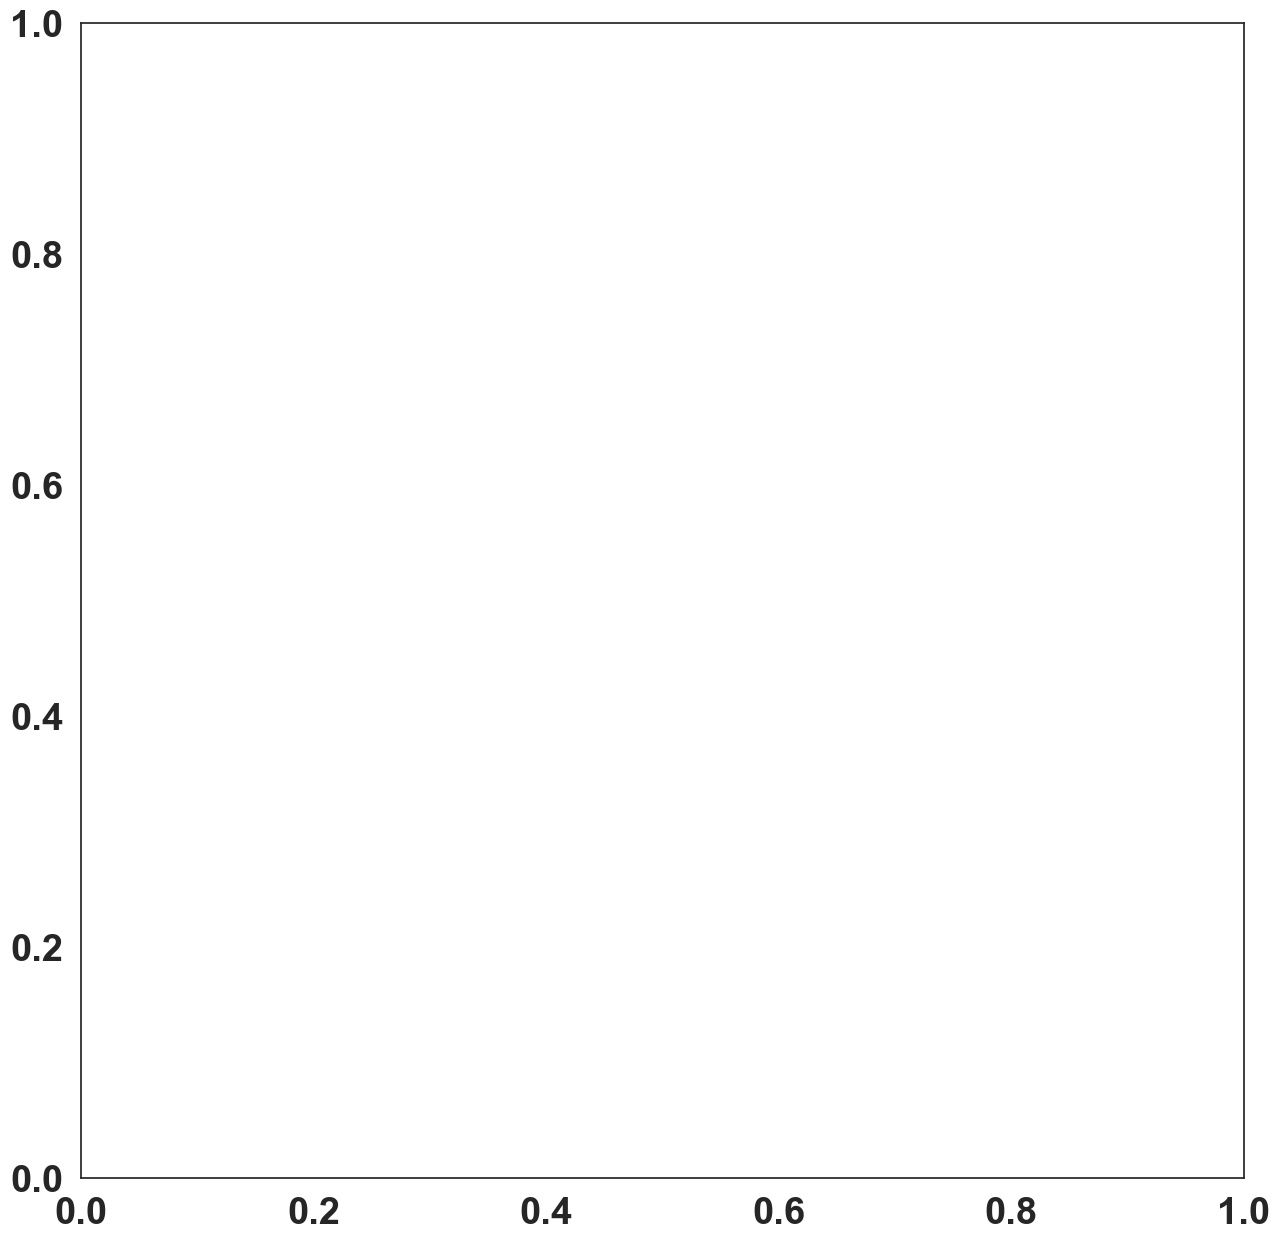

In [89]:
fig,ax=plt.subplots(figsize=(15,15))
plt.imshow(l)

In [90]:
"""
def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, 
                  GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name, 
            Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name
"""

"\ndef CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, \n                  GeoT=None, Projection=None):\n    # If it's a 2D image we fake a third dimension:\n    if len(Array.shape)==2:\n        Array=np.array([Array])\n    if ref_image==None and (GeoT==None or Projection==None):\n        raise RuntimeWarning('ref_image or settings required.')\n    if bandnames != None:\n        if len(bandnames) != Array.shape[0]:\n            raise RuntimeError('Need {} bandnames. {} given'\n                               .format(Array.shape[0],len(bandnames)))\n    else:\n        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]\n    if ref_image!= None:\n        refimg=gdal.Open(ref_image)\n        GeoT=refimg.GetGeoTransform()\n        Projection=refimg.GetProjection()\n    driver= gdal.GetDriverByName('GTIFF')\n    Array[np.isnan(Array)] = NDV\n    DataSet = driver.Create(Name, \n            Array.shape[2], Array.shape[1], Array.shape[0], DataType)\n    Data

In [91]:
gdal_type=gdal_array.NumericTypeCodeToGDALTypeCode(l.dtype)
gdal_type

NameError: name 'l' is not defined

In [92]:
#Saving Predictions as GeoTIFF:
CreateGeoTiff("./classification/test.tif",l,gdal_type,-9999,["Band_1"],GeoT=meta_data.GetGeoTransform(),Projection=meta_data.GetProjection())

NameError: name 'l' is not defined

In [ ]:
Finally, the predicted probabilities are saved as a GeoTIFF file using the provided function CreateGeoTiff. This GeoTIFF file can be further processed or visualized using GIS software.

## RandomForest

In [91]:
#goto
clf_rf=RandomForestClassifier(n_estimators=300, oob_score=True)

In [92]:

clf_rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300, oob_score=True)

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


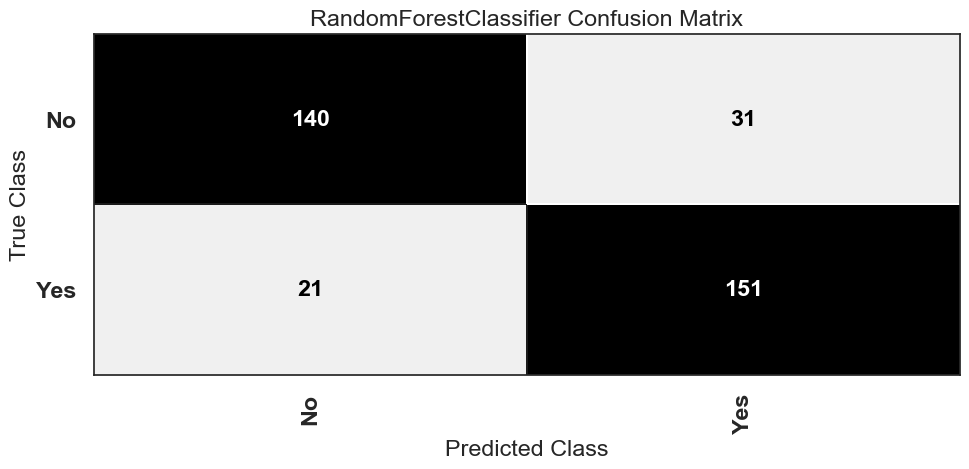

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [93]:
sns.set(style="white",font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
fig,ax=plt.subplots(figsize=(10,5))
cm_rf = ConfusionMatrix(clf_rf, classes=list(class_mapper.values()),cmap="Greys")
cm_rf.fit(X_train,y_train)
cm_rf.score(X_test,y_test)
cm_rf.show()

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


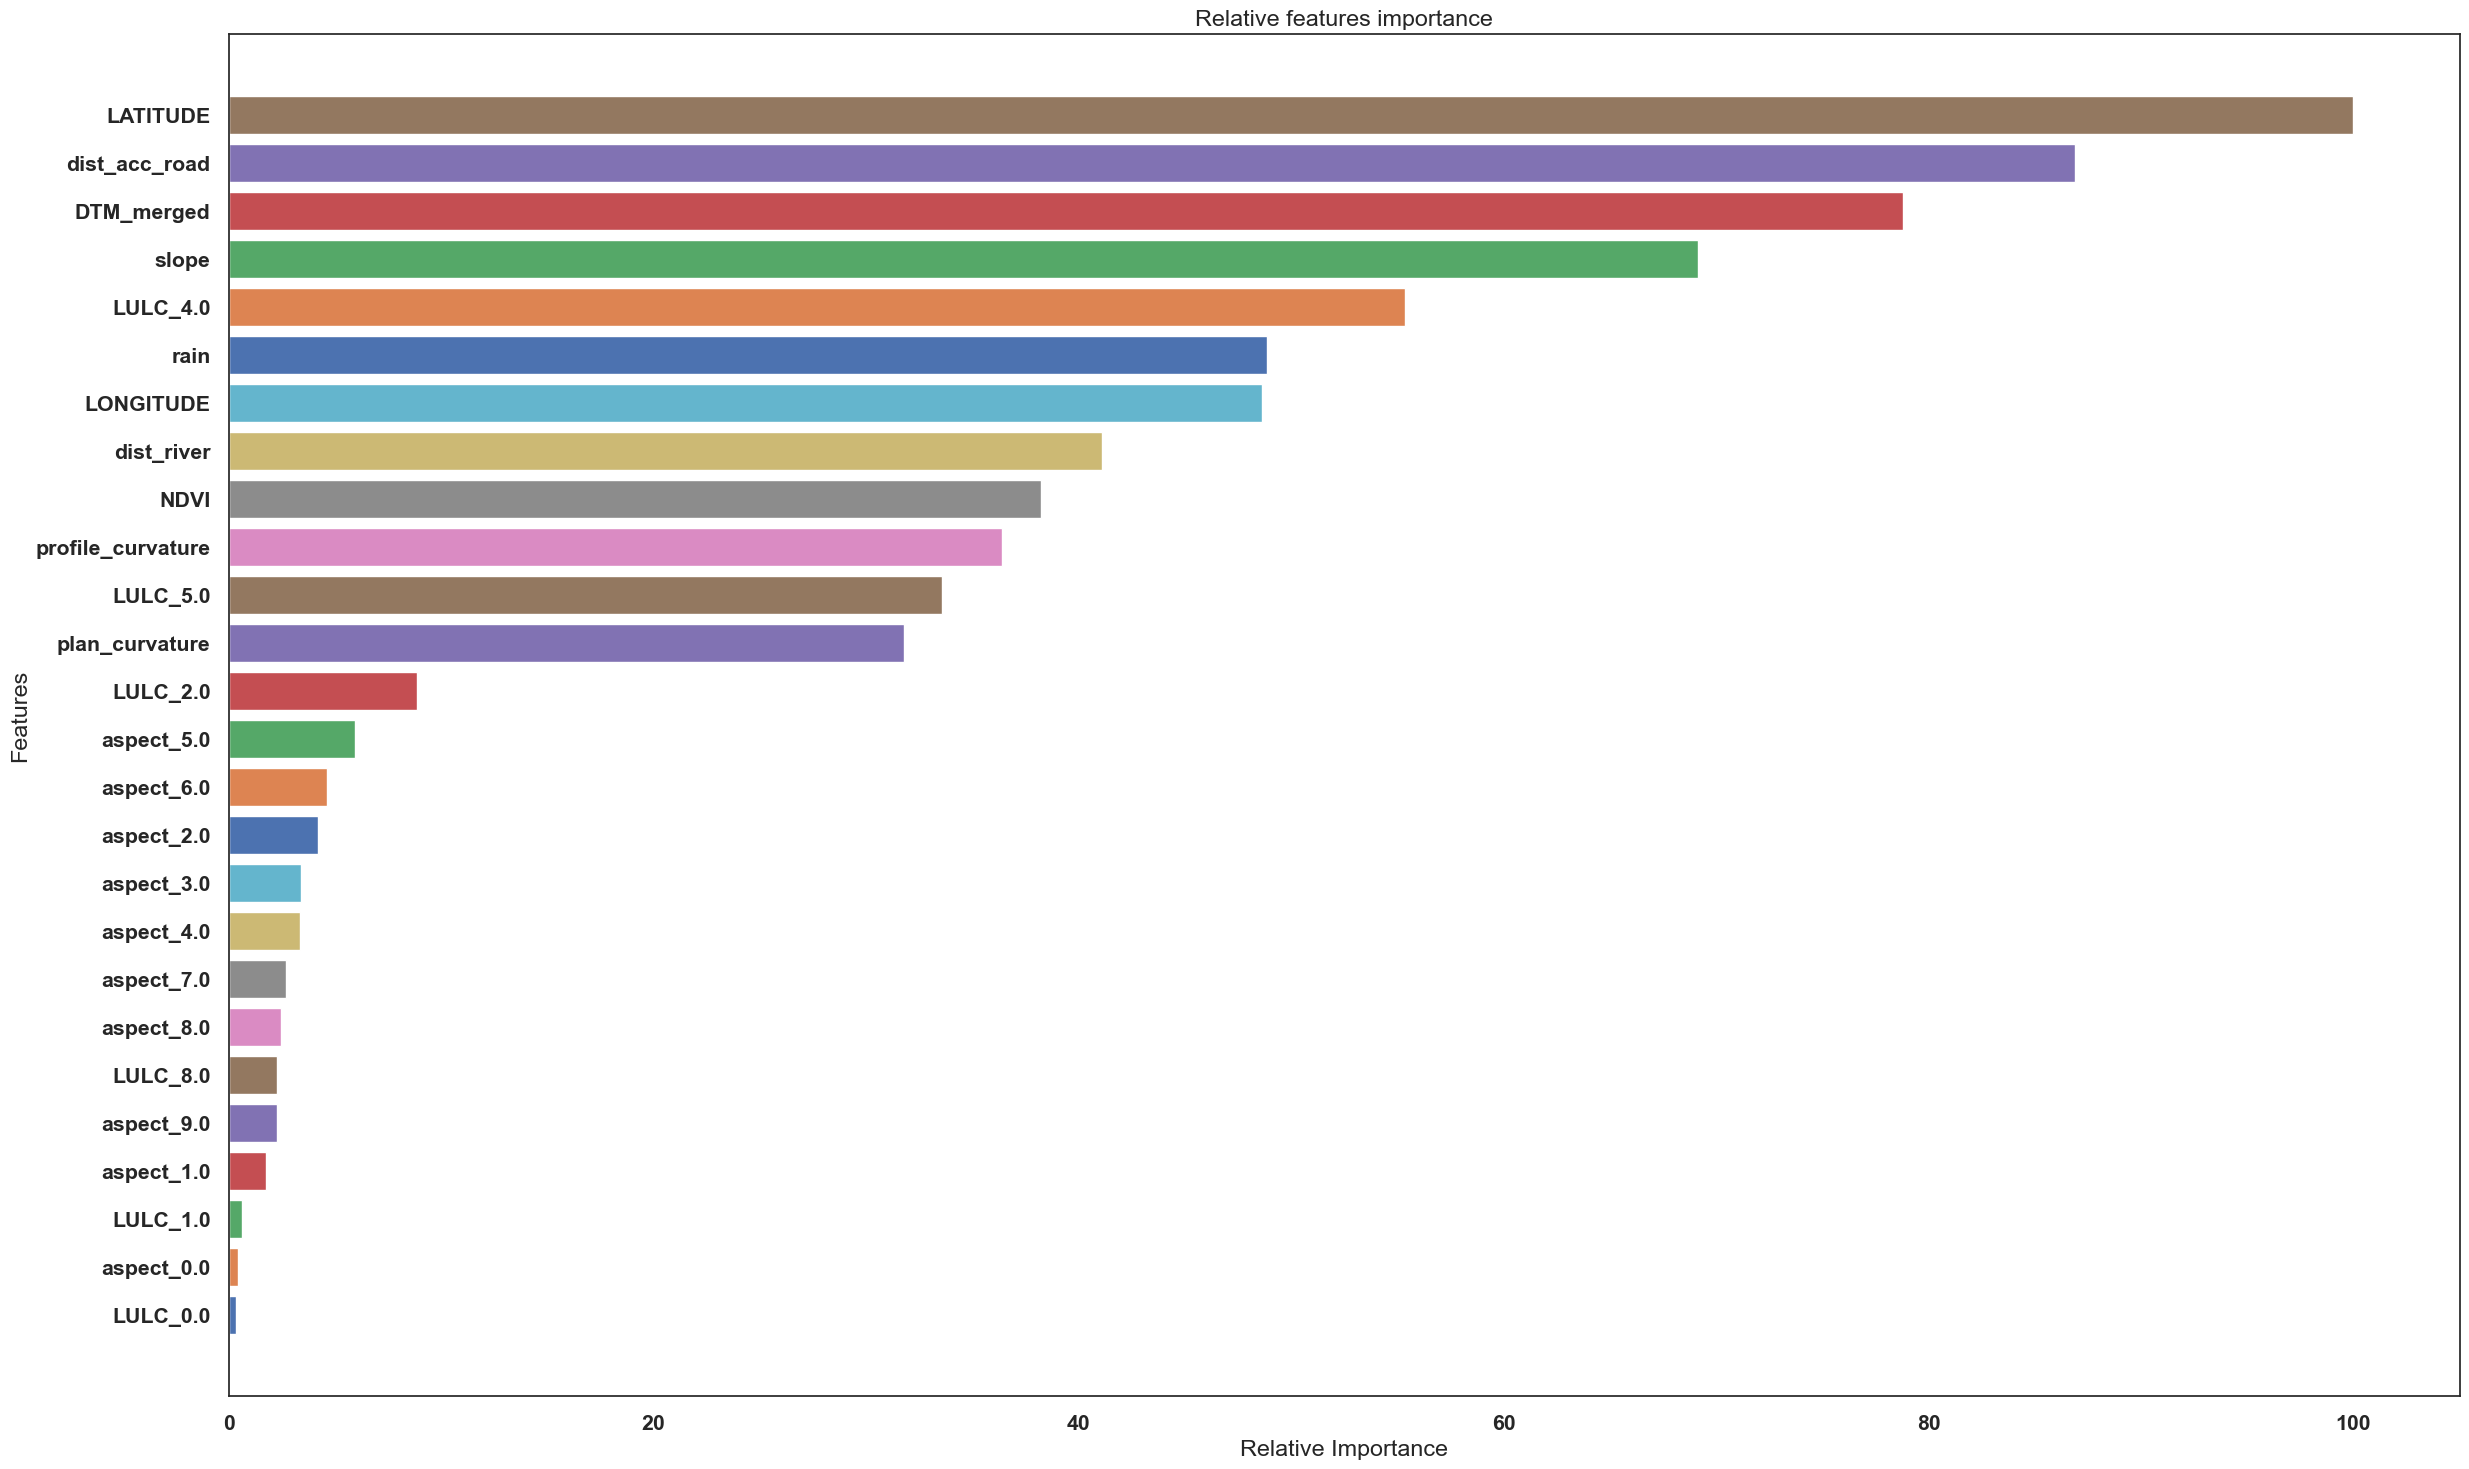

In [94]:
fig,ax=plt.subplots(figsize=(25,15))
viz_rf = FeatureImportances(clf_rf, relative=True, ax=ax)

viz_rf.fit(X_train, y_train)
ax.set(title="Relative features importance", ylabel="Features", xlabel="Relative Importance")
fig.tight_layout()


C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


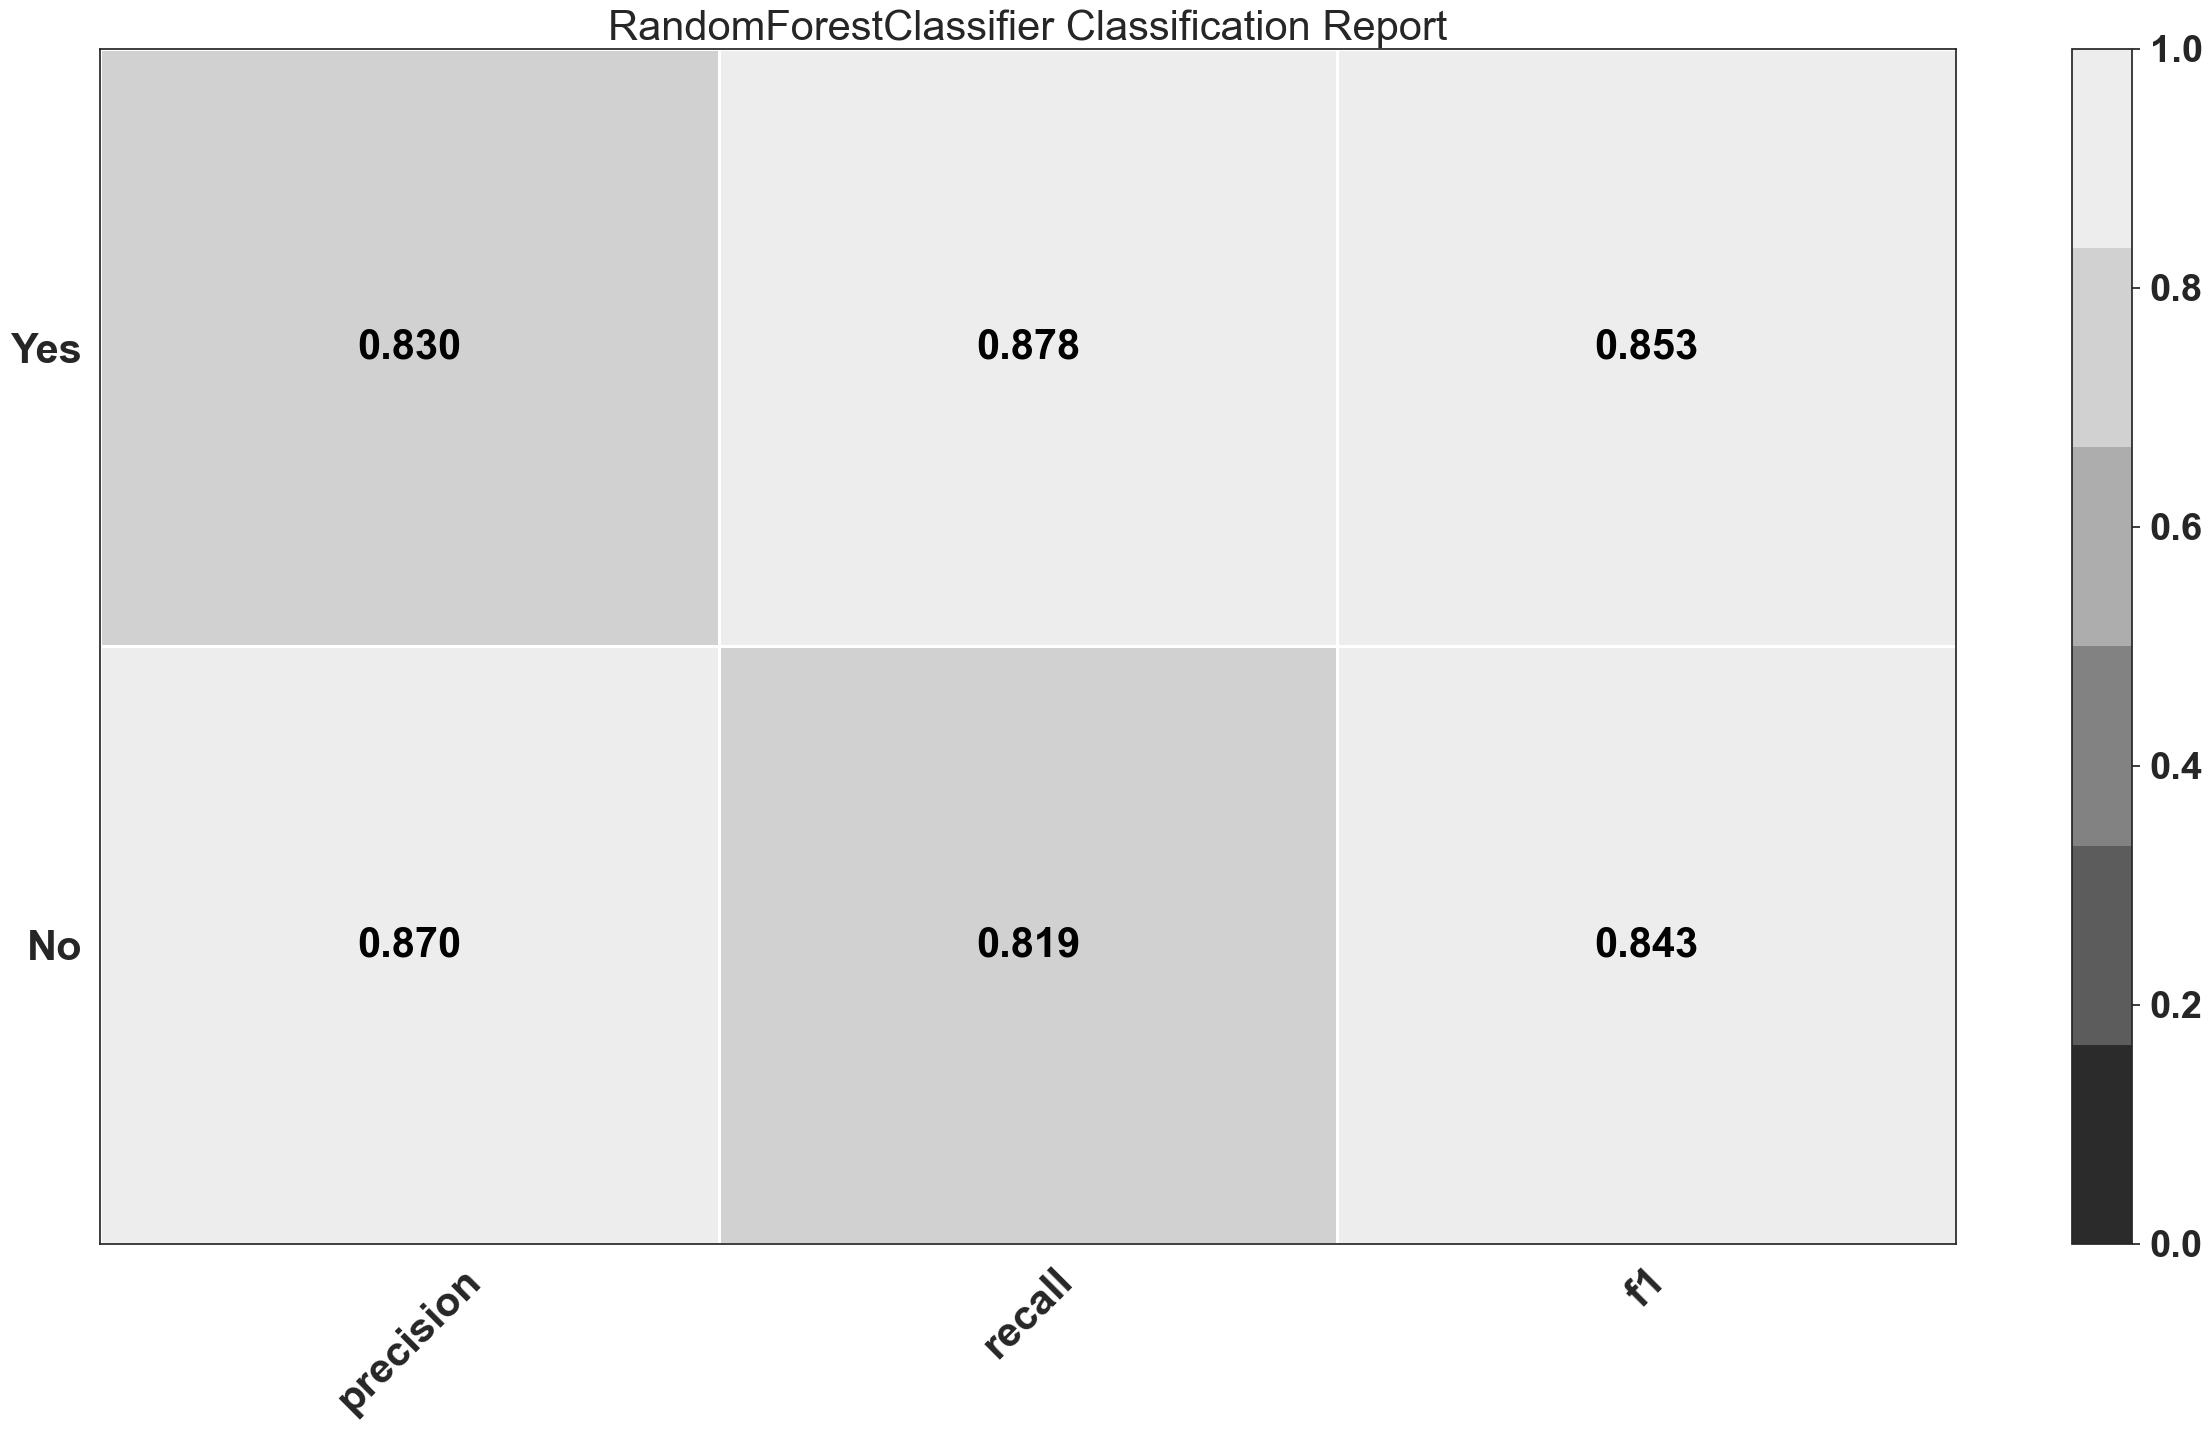

In [95]:

visualizer_rf = ClassificationReport(clf_rf, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=2.5, rc={"font.weight": "bold"})
sns.set_style(style="white")
fig,ax=plt.subplots(figsize=(25,15))
visualizer_rf.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer_rf.score(X_test, y_test)        # Evaluate the model on the test data
visualizer_rf.show(outpath="./accuracy_assessment_random_forest.png")    
fig.tight_layout()

In [96]:
# Making predictions using the XGBoost model
#predictions = clf_xgb.predict(full_data_array_df_encoded)
predictions_rf = clf_rf.predict_proba(full_data_array_df_encoded)
#probability of occurence 
predictions_occ_rf=predictions[:,1]
l_rf=predictions_occ_rf.reshape(dimension[1:])

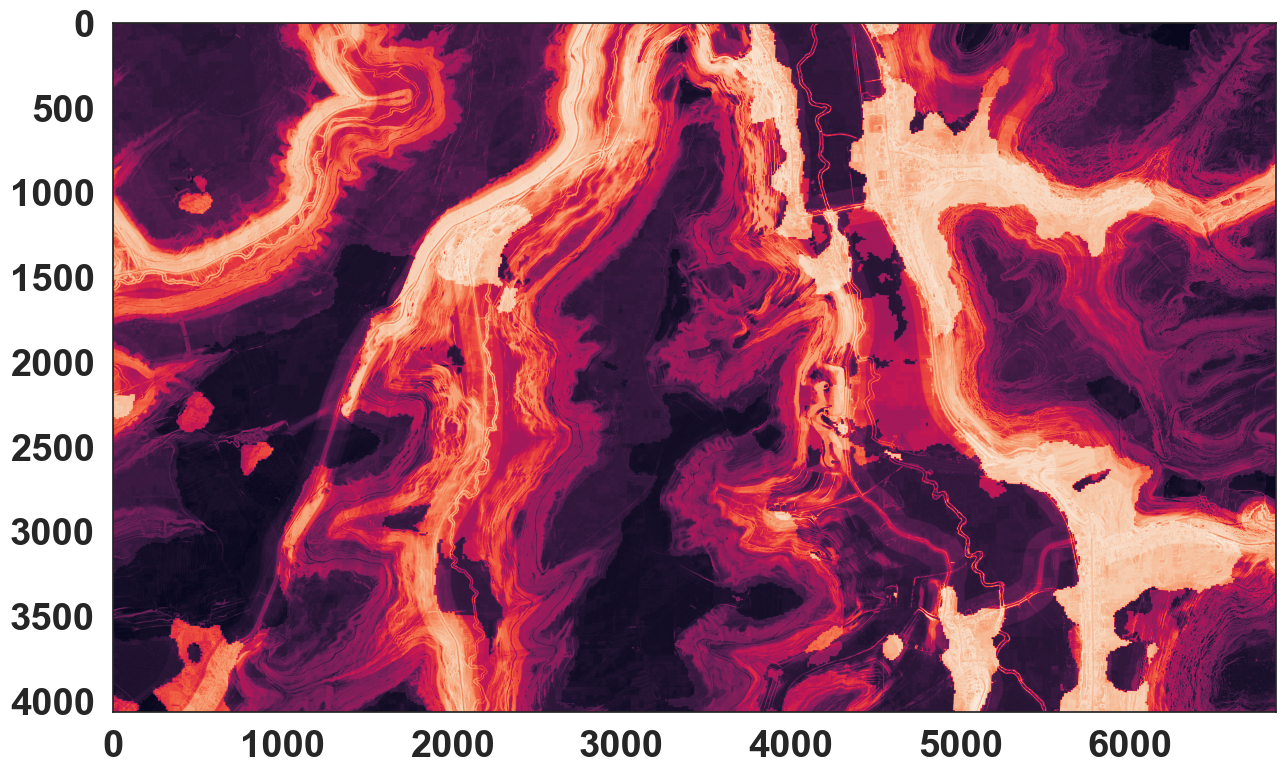

In [97]:
fig,ax=plt.subplots(figsize=(15,15))
plt.imshow(l_rf)

In [98]:
CreateGeoTiff("./classification/test_rf.tif",l_rf,gdal_type,-9999,["Band_1"],GeoT=meta_data.GetGeoTransform(),Projection=meta_data.GetProjection())

'./classification/test_rf.tif'

In [100]:


# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=1658, oob_score=True)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)




Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


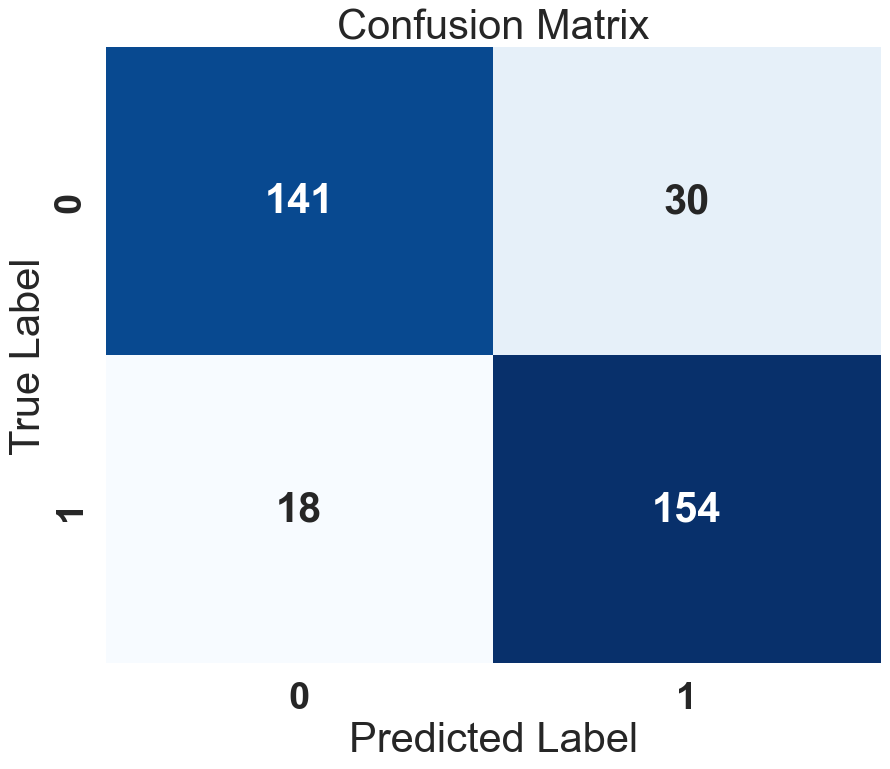

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Instantiate the RandomForestClassifier with the best parameters
best_rf_clf = RandomForestClassifier(random_state=42, oob_score=True, **grid_search.best_params_)

# Train the classifier
best_rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [104]:
import os

In [105]:
os.getcwd()

'C:\\TEMP\\project'

In [ ]:
from ngboost import NGBClassifier
from sklearn.metrics import roc_auc_score

# Instantiate the NgBoost classifier
clf_ngb = NGBClassifier(n_estimators=100, learning_rate=0.01, verbose=True, random_state=42)

# Fit the classifier to the training data
clf_ngb.fit(X_train, y_train)

# Predict probabilities for the test data
y_prob_ngb = clf_ngb.predict_proba(X_test)[:, 1]

# Evaluate the model's performance (e.g., using ROC AUC)
auc_ngb = roc_auc_score(y_test, y_prob_ngb)
print("ROC AUC Score (NgBoost):", auc_ngb)


In [107]:
from ngboost import NGBClassifier
from sklearn.metrics import roc_auc_score

# Instantiate the NgBoost classifier
clf_ngb = NGBClassifier(n_estimators=100, learning_rate=0.01, verbose=True, random_state=42)



In [108]:
# Fit the classifier to the training data
clf_ngb.fit(X_train, y_train)

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000


NGBClassifier(n_estimators=100,
              random_state=RandomState(MT19937) at 0x2230D433840)

In [109]:
# Predict probabilities for the test data
y_prob_ngb = clf_ngb.predict_proba(X_test)[:, 1]

# Evaluate the model's performance (e.g., using ROC AUC)
auc_ngb = roc_auc_score(y_test, y_prob_ngb)
print("ROC AUC Score (NgBoost):", auc_ngb)


ROC AUC Score (NgBoost): 0.881748946008432


In [111]:
from ngboost import NGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [112]:

optimal_params.fit(X_train,y_train,
                   verbose=True,
                   eval_set=[(X_test,y_test)])

optimal_params.best_params_  

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[0]	validation_0-aucpr:0.75383
[1]	validation_0-aucpr:0.75165
[2]	validation_0-aucpr:0.78445
[3]	validation_0-aucpr:0.78455
[4]	validation_0-aucpr:0.78820
[5]	validation_0-aucpr:0.78440
[6]	validation_0-aucpr:0.78089
[7]	validation_0-aucpr:0.81208
[8]	validation_0-aucpr:0.83142
[9]	validation_0-aucpr:0.84371
[10]	validation_0-aucpr:0.84680
[11]	validation_0-aucpr:0.85124
[12]	validation_0-aucpr:0.85354
[13]	validation_0-aucpr:0.86112
[14]	validation_0-aucpr:0.86464
[15]	validation_0-aucpr:0.87318
[16]	validation_0-aucpr:0.88551
[17]	validation_0-aucpr:0.88494
[18]	validation_0-aucpr:0.88591
[19]	validation_0-aucpr:0.88622
[20]	validation_0-aucpr:0.88622
[21]	validation_0-aucpr:0.88749
[22]	validation_0-aucpr:0.88948
[23]	validation_0-aucpr:0.88596
[24]	validation_0-aucpr:0.88820
[25]	validation_0-aucpr:0.88467
[26]	validation_0-aucpr:0.88292
[27]	validation_0-aucpr:0.88292
[28]	validation_0-aucpr:0.89115
[29]	validation_0-

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 1}

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000


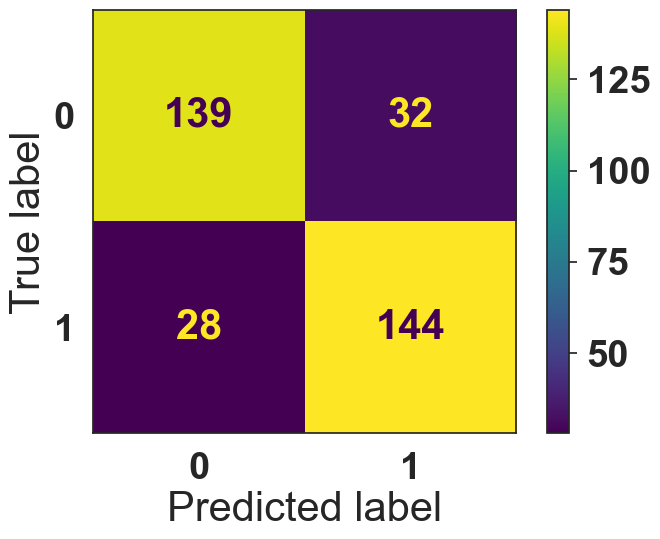

In [115]:
from ngboost import NGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# Assuming you have performed GridSearchCV and stored the results in optimal_params
optimal_params = {
    "n_estimators": 100,  # Example parameter, replace with actual ones
    "learning_rate": 0.01,  # Example parameter, replace with actual ones
    # Add other best parameters found by GridSearchCV
}

# Instantiate the NgBoost classifier with best parameters found by GridSearchCV
clf_ngb = NGBClassifier(verbose=True, random_state=4442, **optimal_params)

# Fit NgBoost classifier to the training data
clf_ngb.fit(X_train, y_train)

# Predictions on the test set
y_pred_ngb = clf_ngb.predict(X_test)

# Calculate confusion matrix
cm_ngb = confusion_matrix(y_test, y_pred_ngb)

# Display confusion matrix
disp_ngb = ConfusionMatrixDisplay(confusion_matrix=cm_ngb)
disp_ngb.plot()
